# Woulda, Coulda, Shoulda : the Sokoban Game

 *Woulda, Coulda, Shoulda : Counterfactually-Guided Policy Search*, **l. Buesing, T. Weber, Y. Zwols et al.** 2018
 
<img src="image/intro.png" width=600 height=100 />


Goal : leverage possible (yet to prove) advantages of *counterfactual* reasoning for learning decision making in RL.

What *would have happened*, had you chose a different action ? Can we simulate counterfactual (and plausible) experiences instead of large amounts of real experiences (which can be costly to acquire)?

Solution : the authors proposed a new algorithm for learning policies in PO-MDPs from off-policy experience, called the Counterfactually-Guided Policy Search (**CF-GPS**). It explicitely considers alternative outcomes, allowing the algorithm to make better use of experience data.

_________________

**<a id="toc"></a>Table of Content**

[1. Sokoban Game](#Sokoban)<br>
- [a. 10x10 Grid](#10x10)<br>
- [b. 7x7 Grid](#7x7)<br>
- [c. Custom Reset](#Custom-Reset)<br>
- [d. Generate Levels](#Generate-Levels)<br>

_______________________________

Packages

In [88]:
import os
import torch
import numpy as np
from torch import tensor
import matplotlib.pyplot as plt
%matplotlib inline

_______________________________

# <a id="Sokoban"></a> Sokoban Game <span  style="float:right">[[toc]](#toc)</span >

The *Sokoban* game is a japanese puzzle that an agent is suppose to solve by pushing different boxes onto targets. 

  **Description** : an agent is sutuated in a $10 \times 10$ grid world (or $7 \times 7$ for the *small* version) and is allowed to take five actions, which are moving (and pushing) to one of four adjacent tiles, plus a NOOP operation. The goal is to push two or three boxes onto two or three immobile targets. As boxes cannot be pulled, many actions results irreversibly in unsolvable states. Episode are length $T=50$, pushing a box onto a target yieds a reward of 1, removing a box from a target yiels a reward of -1 and solving a level results in a additional reward of 10.

*Latest Version*

In [83]:
import gym
import gym_sokoban
from sokoban_wrappers import make_sokoban, render_po, render_full, ResetfromBuffer

import random ; random.seed(1)

### 10x10

Action Meaning : {0: 'no operation', 1: 'push up', 2: 'push down', 3: 'push left', 4: 'push right'} 
Observation Space : Box(10, 10, 7)


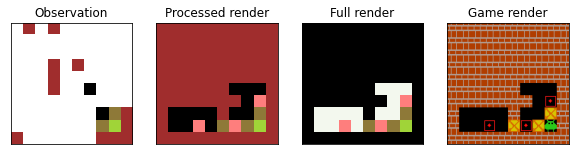

In [84]:
env = make_sokoban(po_wrapper=True, action_wrapper=True, mask_proba=0.9)
obs = env.reset()
print('Action Meaning :', env.get_action_meanings(), '\nObservation Space :', env.observation_space)

fig, ax = plt.subplots(1,4, figsize=(10,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
render = [env.render(mode=mode) for mode in ['tiny_rgb_array', 'rgb_array']]
ax[0].imshow(render_po(obs)) ; ax[0].set_title('Observation')
ax[1].imshow(render_full(env.room_state)) ; ax[1].set_title('Processed render')
ax[2].imshow(render[0]) ; ax[2].set_title('Full render')
ax[3].imshow(render[1]) ; ax[3].set_title('Game render') ; plt.show()

Remarks : 
1. as generating a room of size 10x10 that complies with all the constraint (nb of boxes and targets, solvable levels etc ..), it takes a non-negligeable timme to reset the environement. It goes so much faster with a 7x7 room, as constraints are ligther.
2. setting the seed fixes the grid layout but not the item's position.

### 7x7

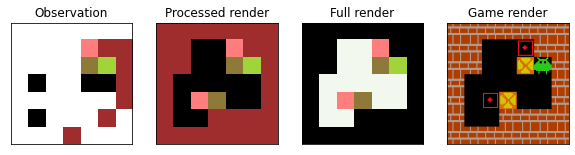

In [88]:
env = make_sokoban(env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.9)
obs = env.reset()

fig, ax = plt.subplots(1,4, figsize=(10,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
render = [env.render(mode=mode) for mode in ['tiny_rgb_array', 'rgb_array']]
ax[0].imshow(render_po(obs)) ; ax[0].set_title('Observation')
ax[1].imshow(render_full(env.room_state)) ; ax[1].set_title('Processed render')
ax[2].imshow(render[0]) ; ax[2].set_title('Full render')
ax[3].imshow(render[1]) ; ax[3].set_title('Game render') ; plt.show()

### Custom Reset

We added a additinal wrapper to allow a player to reset the environment by providing the initial room configuration

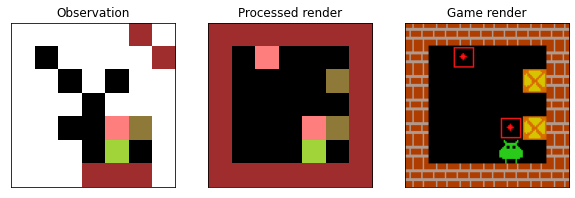

In [11]:
array = np.array([[0,0,0,0,0,0,0],
                  [0,1,2,1,1,1,0],
                  [0,1,1,1,1,4,0],
                  [0,1,1,1,1,1,0],
                  [0,1,1,1,2,4,0],
                  [0,1,1,1,5,1,0],
                  [0,0,0,0,0,0,0]], dtype = np.uint8)

env = make_sokoban(env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.7, allow_reset=True)
obs = env.reset(**{'array':array})

fig, ax = plt.subplots(1,3, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
ax[0].imshow(render_po(obs)) ; ax[0].set_title('Observation')
ax[1].imshow(render_full(env.room_state)) ; ax[1].set_title('Processed render')
ax[2].imshow(env.render(mode='rgb_array')) ; ax[2].set_title('Game render') ;

To simplify training we generated a buffer of solvable levels which the environement will be sampling its initial state from. Argument *allow_reset* set to True.

Room nb: 20


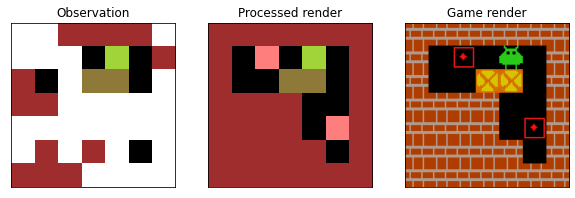

In [12]:
env = make_sokoban(env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.7, allow_reset=True)
env = ResetfromBuffer(env, 100) ; obs = env.reset()
print('Room nb:', env.rand)

fig, ax = plt.subplots(1,3, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
ax[0].imshow(render_po(obs)) ; ax[0].set_title('Observation')
ax[1].imshow(render_full(env.room_state)) ; ax[1].set_title('Processed render')
ax[2].imshow(env.render(mode='rgb_array')) ; ax[2].set_title('Game render') ;

The generated levels can be found in the following numpy-like file :
    
    rooms = np.load('rooms7x7.npy')
    plt.imshow(render_full(rooms[id]))



### Generate Levels

**Generate levels and save into buffer**

In [13]:
from tqdm import tqdm_notebook as pbar
import numpy as np

if False :
    
    nb_room_generated = 1000
    rooms = np.zeros((nb_room_generated,7,7), dtype=np.uint8)
    
    for r in pbar(range(nb_room_generated)):
        env = make_sokoban(env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.7)
        room = env.room_state
        rooms[r] = room     
        np.save('data/rooms7x7.npy', rooms)

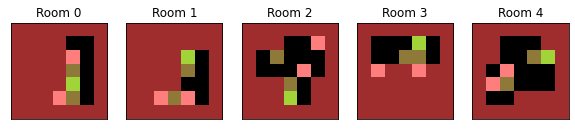

In [14]:
rooms = np.load('data/rooms7x7.npy')

fig, ax = plt.subplots(1,5, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;

for i in range(5):
    ax[i].imshow(render_full(rooms[i])) ; ax[i].set_title('Room {}'.format(i))

_______________________